In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import models, layers , optimizers
import keras
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.utils import to_categorical, plot_model
import random
from tensorflow.keras.preprocessing import image

In [2]:
dataset_path = '/kaggle/input/brain-tumors-256x256/Data'

In [3]:
def create_dataframe(dataset_path):
    filepaths = []
    labels = []
    
    for folder in os.listdir(dataset_path):
        folder_path = os.path.join(dataset_path, folder)
        if os.path.isdir(folder_path):
            imgList = os.listdir(folder_path)
            for img in imgList:
                img_path = os.path.join(folder_path, img)
                filepaths.append(img_path)
                labels.append(folder)
                
    fseries = pd.Series(filepaths, name = "Filepaths")
    lseries = pd.Series(labels, name = "Labels")
    return pd.concat([fseries, lseries], axis = 1)

df = create_dataframe(dataset_path)
df

,Filepaths,Labels
0,/kaggle/input/brain-tumors-256x256/Data/pituit...,pituitary_tumor
1,/kaggle/input/brain-tumors-256x256/Data/pituit...,pituitary_tumor
2,/kaggle/input/brain-tumors-256x256/Data/pituit...,pituitary_tumor
3,/kaggle/input/brain-tumors-256x256/Data/pituit...,pituitary_tumor
4,/kaggle/input/brain-tumors-256x256/Data/pituit...,pituitary_tumor
...,...,...
3091,/kaggle/input/brain-tumors-256x256/Data/normal...,normal
3092,/kaggle/input/brain-tumors-256x256/Data/normal...,normal
3093,/kaggle/input/brain-tumors-256x256/Data/normal...,normal
3094,/kaggle/input/brain-tumors-256x256/Data/normal...,normal


In [4]:
# 80% Training & 20% Dummy
train_df, dummy_df = train_test_split(df, train_size = 0.8, shuffle = True, random_state = 42)

# Dummy => 10% Test & 10% Validation
test_df, validation_df = train_test_split(dummy_df, train_size = 0.5, shuffle = True, random_state = 42)

In [5]:
print(train_df.shape)
print(dummy_df.shape)
print(validation_df.shape)
print(test_df.shape)

(2476, 2)
(620, 2)
(310, 2)
(310, 2)


In [6]:
train_datagen = ImageDataGenerator(rescale = 1./255)
validation_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

In [7]:
train_generator = train_datagen.flow_from_dataframe(
    dataframe = train_df,
    x_col = "Filepaths",
    y_col = "Labels",
    target_size = (224, 224),
    batch_size = 32,
    class_mode = 'categorical',
    shuffle = True
    )

validation_generator = validation_datagen.flow_from_dataframe(
    dataframe = validation_df,
    x_col = "Filepaths",
    y_col = "Labels",
    target_size = (224, 224),
    batch_size = 32,
    class_mode = 'categorical',
    shuffle = False
    )

test_generator = test_datagen.flow_from_dataframe(
    dataframe = test_df,
    x_col = "Filepaths",
    y_col = "Labels",
    target_size = (224, 224),
    batch_size = 32,
    class_mode = 'categorical',
    shuffle = False
    )

Found 2476 validated image filenames belonging to 4 classes.
Found 310 validated image filenames belonging to 4 classes.
Found 310 validated image filenames belonging to 4 classes.


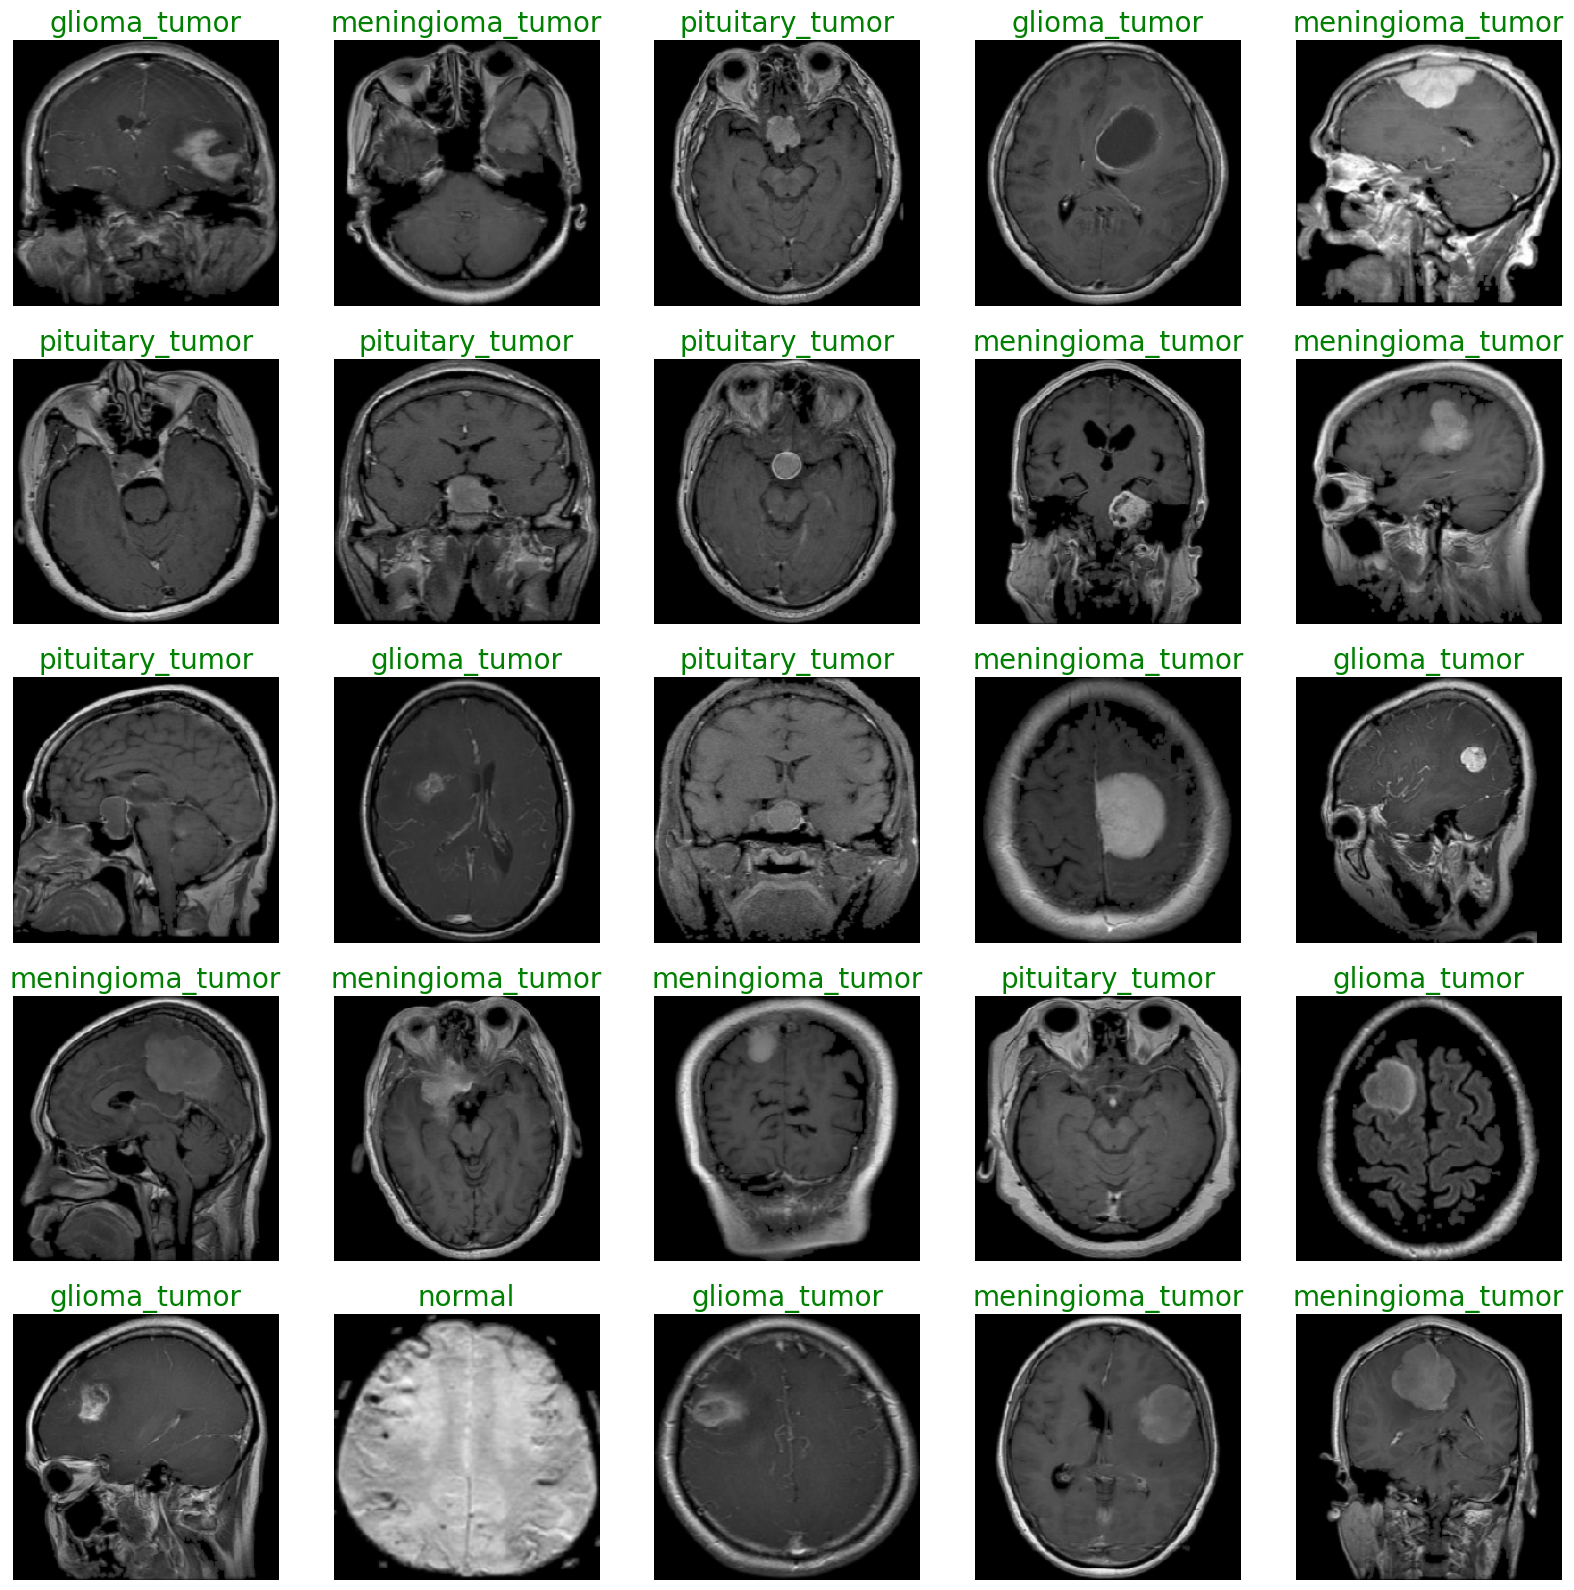

In [8]:
def show_images(image_gen):
    class_dict = image_gen.class_indices
    classes = list(class_dict.keys())
    
    images, labels = next(image_gen)
    
    plt.figure(figsize = (20,20))
    
    num_images = min(len(labels), 25)
    
    for i in range(num_images):
        plt.subplot(5, 5, i + 1)
        
        image = images[i]
        
        plt.imshow(image)
        
        index = np.argmax(labels[i])
        class_name = classes[index]
        
        plt.title(class_name, color = "green", fontsize = 20)
        plt.axis("off")
        
    plt.show()
    
show_images(train_generator)

In [9]:
input_shape = (224, 224, 3)
n_classes = len(train_generator.class_indices)

model = keras.Sequential([
    keras.layers.Conv2D(filters = 32, kernel_size = (3,3), activation = 'relu', input_shape = input_shape), # Input = (224, 224, 3)
    keras.layers.MaxPool2D(pool_size=(2,2)), # Input = (222, 222, 32)

    keras.layers.Conv2D(filters = 64, kernel_size = (5,5), activation = 'relu', padding = 'same'), # Input = (111, 111, 32)
    keras.layers.MaxPool2D(pool_size = (3,3)), # Input = (111, 111, 64)

    keras.layers.Conv2D(filters = 128, kernel_size = (7,7), activation = 'relu', padding = 'same'), # Input = (37, 37, 64)
    keras.layers.MaxPool2D(pool_size = (2,2)), # Input = (37, 37, 128)

    keras.layers.Conv2D(filters = 128, kernel_size = (5,5), activation = 'relu', padding = 'same'), # Input = (18, 18, 128)
    keras.layers.MaxPool2D(pool_size = (3,3)), #Input = (18, 18, 128)

    keras.layers.Conv2D(filters = 128, kernel_size = (3,3), activation = 'relu', padding = 'same'), # Input = (6, 6, 128)
    keras.layers.MaxPool2D(pool_size = (3,3)), # Input = (6, 6, 128)

    keras.layers.Flatten(), # Input = (2, 2, 128)
    keras.layers.Dense(256, activation = 'relu'), # Input = (512)
    keras.layers.Dropout(0.5), # Input = (256)

    keras.layers.Dense(n_classes, activation = 'softmax')
])

model.compile(
    loss = 'categorical_crossentropy',
    optimizer = tf.optimizers.Adam(),
    metrics = ['accuracy']
)

model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 111, 111, 64)   │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 37, 37, 128)    │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 18, 18, 128)    │       409,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 6, 6, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,143,364 (4.36 MB)

 Trainable params: 1,143,364 (4.36 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
history = model.fit(
    train_generator,
    batch_size = 32,
    validation_data = validation_generator,
    epochs = 30
)

Epoch 1/30


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1728784437.165832      67 service.cc:145] XLA service 0x7f0e980048e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1728784437.165900      67 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


 1/78 ━━━━━━━━━━━━━━━━━━━━ 15:13 12s/step - accuracy: 0.2500 - loss: 1.3844

I0000 00:00:1728784444.584456      67 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


78/78 ━━━━━━━━━━━━━━━━━━━━ 37s 333ms/step - accuracy: 0.3067 - loss: 1.3717 - val_accuracy: 0.3516 - val_loss: 1.2748
Epoch 2/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 6s 75ms/step - accuracy: 0.4349 - loss: 1.1954 - val_accuracy: 0.6290 - val_loss: 0.8537
Epoch 3/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 6s 73ms/step - accuracy: 0.5940 - loss: 0.9346 - val_accuracy: 0.7065 - val_loss: 0.7391
Epoch 4/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 7s 77ms/step - accuracy: 0.6715 - loss: 0.7705 - val_accuracy: 0.6806 - val_loss: 0.7785
Epoch 5/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 6s 73ms/step - accuracy: 0.7740 - loss: 0.5775 - val_accuracy: 0.7871 - val_loss: 0.6203
Epoch 6/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 10s 70ms/step - accuracy: 0.8005 - loss: 0.5045 - val_accuracy: 0.7871 - val_loss: 0.5186
Epoch 7/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 6s 69ms/step - accuracy: 0.8363 - loss: 0.4030 - val_accuracy: 0.8000 - val_loss: 0.5365
Epoch 8/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 10s 72ms/step - accuracy: 0.8852 - loss: 0.3224 - val_accuracy: 0.8452 - val_loss

In [11]:
scores = model.evaluate(test_generator)
scores

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 179ms/step - accuracy: 0.9552 - loss: 0.2588


[0.28571903705596924, 0.9548386931419373]

In [12]:
test_generator.reset()
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis = 1)

true_classes = test_generator.classes

class_labels = list(test_generator.class_indices.keys())
report = classification_report(true_classes, predicted_classes, target_names = class_labels)
print(report)

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step
                  precision    recall  f1-score   support

    glioma_tumor       0.99      0.96      0.97        89
meningioma_tumor       0.93      0.92      0.93        93
          normal       1.00      0.94      0.97        35
 pituitary_tumor       0.93      0.99      0.96        93

        accuracy                           0.95       310
       macro avg       0.96      0.95      0.96       310
    weighted avg       0.96      0.95      0.95       310



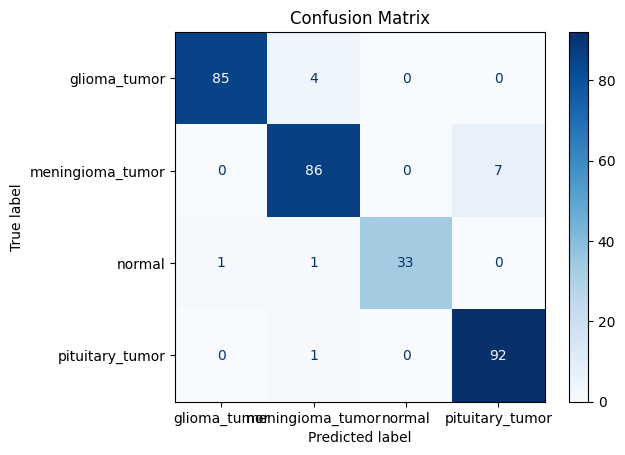

In [13]:
cm = confusion_matrix(true_classes, predicted_classes)

disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = test_generator.class_indices)
disp.plot(cmap = plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

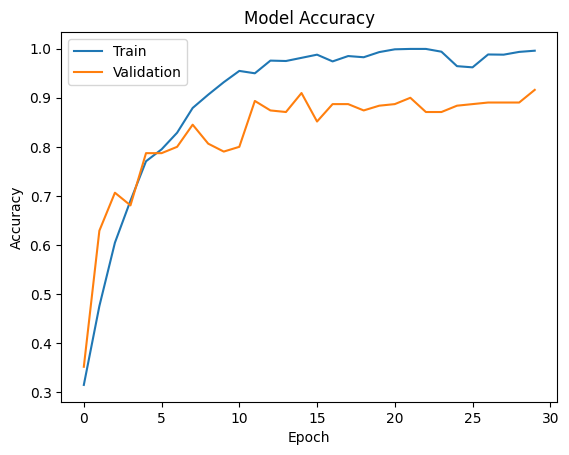

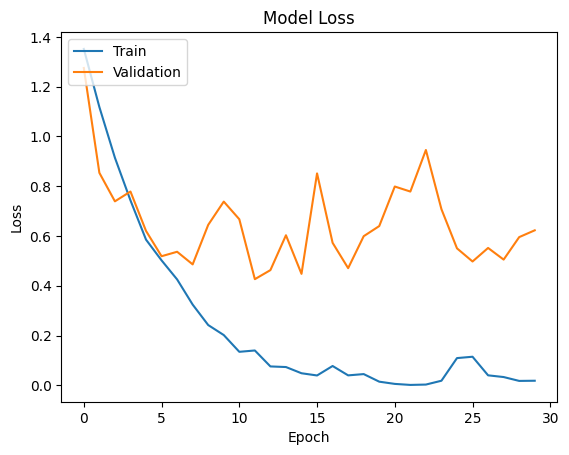

In [14]:
#Accuracy Plot
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'upper left')
plt.show()

#Loss Plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'upper left')
plt.show()

In [15]:
model.save('Model_1.h5')